# PyTorch에서 데이터 다루기

## Dataset 살펴보기 : 간단한 데이터

### Dataset 클래스 만들기

In [ ]:
import torch

Dataset 클래스는 데이터셋과 레이블을 관리하기 편리하게 만들어 주는 PyTorch의 유틸리티입니다. 커스텀 데이터셋을 정의하면, 데이터셋의 크기와 특정 인덱스 데이터를 쉽게 확인할 수 있습니다.

이번 예제에서는 간단한 2차원 데이터와 이진 레이블을 활용해 Dataset 클래스를 만들어보겠습니다.

In [ ]:
# Dataset 클래스를 상속받아 커스텀 데이터셋을 정의합니다.
from torch.utils.data import Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self):
        self.x = [
            [10, 20],
            [20, 15],
            [15, 15],
            [80, 90],
            [85, 80],
            [85, 90],
        ]
        self.y = [0, 0, 0, 1, 1, 1]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        input_data = self.x[index]
        label = self.y[index]
        return torch.tensor(input_data), torch.tensor(label)

사용자 정의 Dataset 클래스는 __init__ , __len__ , __getitem__ 의 세 가지 함수를 구현해야 합니다

- `__init__` 메소드는 클래스가 초기화될 때 실행됩니다. 데이터의 경로나 전처리를 정의하며, 간단한 데이터라면 여기에서 바로 데이터를 정의할 수도 있습니다.

- `__len__` 메소드는 데이터 셋에 있는 샘플의 개수를 반환합니다.

- `__getitem__` 메소드는 특정 인덱스의 데이터를 반환합니다.

### Dataset 객체 사용하기

In [ ]:
### 객체 생성
custom_dataset = CustomDataset()

In [ ]:
### 데이터 개수 확인
len(custom_dataset)

6

In [ ]:
### 특정 인덱스 데이터 확인
custom_dataset[0]

(tensor([10, 20]), tensor(0))

In [ ]:
custom_dataset[3]

(tensor([80, 90]), tensor(1))

## CSV 데이터 활용하기

 실제 데이터를 담고 있는 CSV 파일을 활용하여 PyTorch의 Dataset 클래스를 정의하고 사용하는 방법을 배워보겠습니다.

In [ ]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

전복(Abalone) 데이터셋을 판다스를 사용해 읽어옵니다.

이 데이터는 전복의 크기, 무게, 그리고 나이 정보를 포함하고 있습니다.

In [ ]:
abalone_df = pd.read_csv(
    'https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv',
    names=['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
           'Viscera weight', 'Shell weight', 'Age']
)

In [ ]:
abalone_df.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


결과를 보면, 길이, 직경, 높이 같은 크기 정보와 무게, 나이 정보가 잘 나옵니다.

이 데이터를 사용하여 전복의 나이를 예측하는 회귀 문제를 설정하겠습니다.

- **`input_data`**: 나이를 제외한 나머지 데이터 (입력)
- **`target_data`**: 전복의 나이 (타깃)

In [ ]:
input_data = abalone_df.drop(columns=['Age']).to_numpy().astype(np.float32)
target_data = abalone_df['Age'].to_numpy().astype(np.float32)

In [ ]:
class AbaloneDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index])
        target_tensor = torch.tensor(self.target_data[index])

        return input_tensor, target_tensor

In [ ]:
abalone_dataset = AbaloneDataset(input_data, target_data)

print(len(abalone_dataset))
print(abalone_dataset[0])

3320
(tensor([0.4350, 0.3350, 0.1100, 0.3340, 0.1355, 0.0775, 0.0965]), tensor(7.))


## 이미지 데이터

데이터 크기가 너무 커서 메모리에 모두 올리기 어려운 경우를 대비해 PyTorch Dataset 클래스를 활용하는 방법을 배워봅니다.

In [ ]:
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

In [ ]:
# 다양한 꽃 이미지 데이터가 담긴 flower_photos 폴더를 다운로드하고 압축을 해제합니다.

!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar -xvf ./flower_photos.tgz > /dev/null 2>&1


--2025-06-09 14:13:54--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   224MB/s    in 1.0s    

2025-06-09 14:13:55 (224 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
import glob
image_path = glob.glob("/content/flower_photos/*/*.jpg")

In [ ]:
image_path

['/content/flower_photos/dandelion/5598845098_13e8e9460f.jpg',
 '/content/flower_photos/dandelion/494108764_e00178af6e.jpg',
 '/content/flower_photos/dandelion/3398195641_456872b48b_n.jpg',
 '/content/flower_photos/dandelion/7197581386_8a51f1bb12_n.jpg',
 '/content/flower_photos/dandelion/2995221296_a6ddaccc39.jpg',
 '/content/flower_photos/dandelion/18970601002_d70bc883a9.jpg',
 '/content/flower_photos/dandelion/14368895004_c486a29c1e_n.jpg',
 '/content/flower_photos/dandelion/4632761610_768360d425.jpg',
 '/content/flower_photos/dandelion/14313509432_6f2343d6c8_m.jpg',
 '/content/flower_photos/dandelion/14171812905_8b81d50eb9_n.jpg',
 '/content/flower_photos/dandelion/3464015936_6845f46f64.jpg',
 '/content/flower_photos/dandelion/7099259755_1c66420206_n.jpg',
 '/content/flower_photos/dandelion/2553703483_558d12668c_n.jpg',
 '/content/flower_photos/dandelion/144040769_c5b805f868.jpg',
 '/content/flower_photos/dandelion/14884028290_a1344eb446.jpg',
 '/content/flower_photos/dandelion/247

In [ ]:
image_path_all = glob.glob("/content/**/*.jpg", recursive=True)
image_path_all

['/content/flower_photos/dandelion/5598845098_13e8e9460f.jpg',
 '/content/flower_photos/dandelion/494108764_e00178af6e.jpg',
 '/content/flower_photos/dandelion/3398195641_456872b48b_n.jpg',
 '/content/flower_photos/dandelion/7197581386_8a51f1bb12_n.jpg',
 '/content/flower_photos/dandelion/2995221296_a6ddaccc39.jpg',
 '/content/flower_photos/dandelion/18970601002_d70bc883a9.jpg',
 '/content/flower_photos/dandelion/14368895004_c486a29c1e_n.jpg',
 '/content/flower_photos/dandelion/4632761610_768360d425.jpg',
 '/content/flower_photos/dandelion/14313509432_6f2343d6c8_m.jpg',
 '/content/flower_photos/dandelion/14171812905_8b81d50eb9_n.jpg',
 '/content/flower_photos/dandelion/3464015936_6845f46f64.jpg',
 '/content/flower_photos/dandelion/7099259755_1c66420206_n.jpg',
 '/content/flower_photos/dandelion/2553703483_558d12668c_n.jpg',
 '/content/flower_photos/dandelion/144040769_c5b805f868.jpg',
 '/content/flower_photos/dandelion/14884028290_a1344eb446.jpg',
 '/content/flower_photos/dandelion/247

In [ ]:
# from torchvision.transforms import ToTensor, ToPILImage
# totensor = ToTensor()

class FlowerDataset(Dataset):
  def __init__(self):
      self.image_paths = glob.glob('/content/flower_photos/*/*.jpg')

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    image_path = self.image_paths[index]
    image = Image.open(image_path)
    image_np = np.array(image)
    return torch.tensor(image_np)
    # return totensor(image)

In [ ]:
dataset = FlowerDataset()

In [ ]:
len(dataset)

3670

In [ ]:
import matplotlib.pyplot as plt

def show_image(image_tensor):
  image = image_tensor.numpy()
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

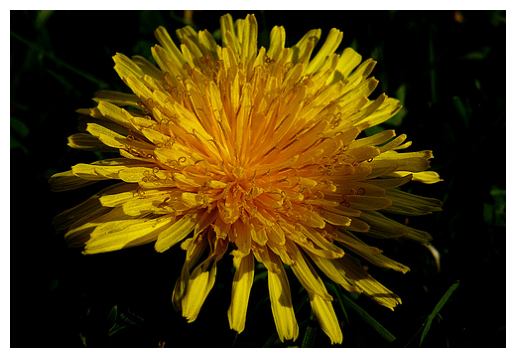

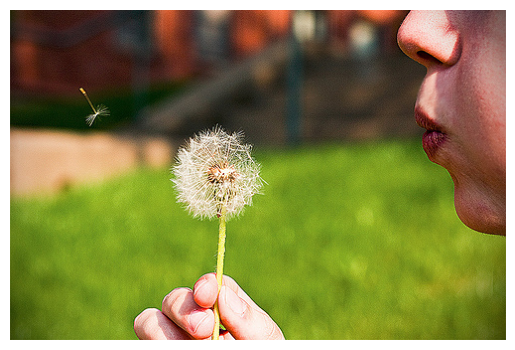

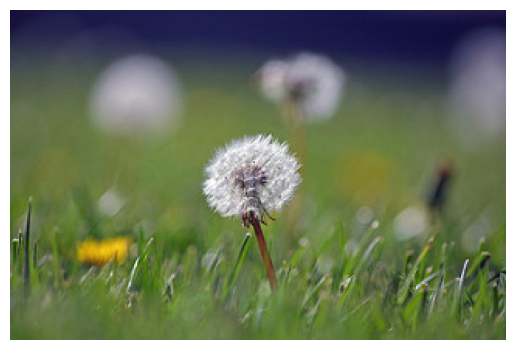

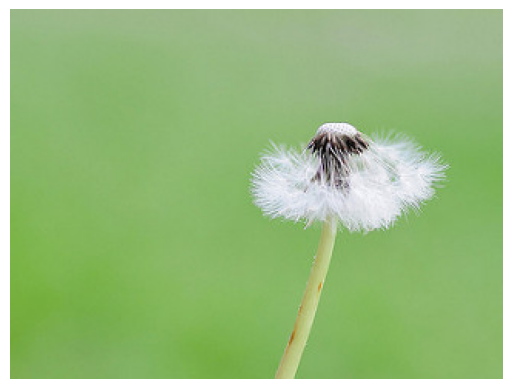

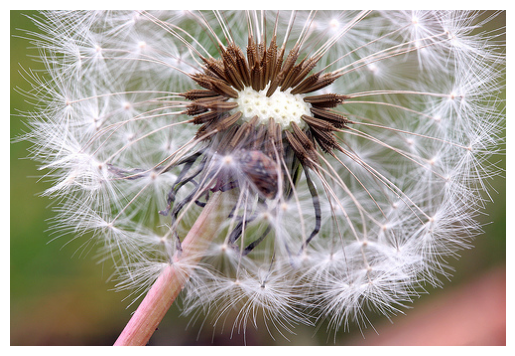

In [ ]:
for i in range(5):
    show_image(dataset[i])

## 실습

scikit-learn에서 California Housing 데이터셋을 불러온 뒤, 입력은 `input_data`에 저장하고 타깃은 `target_data`에 저장하세요.이때 `input_data`와 `target_data` 모두 데이터 타입은 float32로 지정해주세요.

California Housing 데이터셋의 입력과 타깃을 짝지어 관리하는 커스텀 Dataset 클래스 `CaliforniaHousingDataset`을 정의해 주세요.
   
코드 마지막 부분에서 0번 인덱스 데이터를 출력했을 때 다음과 같은 결과가 나와야 합니다.



```
(tensor([   8.3252,   41.0000,    6.9841,    1.0238,  322.0000,    2.5556,
          37.8800, -122.2300]), tensor(4.5260))
```

In [ ]:
import numpy as np
from sklearn import datasets

import torch
from torch.utils.data import Dataset

cal_housing = datasets.fetch_california_housing()
input_data = cal_housing.data.astype(np.float32)
target_data = cal_housing.target.astype(np.float32)

In [ ]:
# 코드를 작성해 주세요

In [ ]:
dataset = CaliforniaHousingDataset(input_data, target_data)
print(dataset[0])

(tensor([   8.3252,   41.0000,    6.9841,    1.0238,  322.0000,    2.5556,
          37.8800, -122.2300]), tensor(4.5260))


## 데이터 분할과 표준화

PyTorch에서 데이터셋을 학습, 검증, 테스트로 분할하고, 데이터를 표준화하는 과정을 배웁니다.

In [ ]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset


In [ ]:
abalone_df = pd.read_csv(
    'https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv',
    names=['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
           'Viscera weight', 'Shell weight', 'Age']
)

input_data = abalone_df.drop(columns=['Age']).to_numpy().astype(np.float32)
target_data = abalone_df['Age'].to_numpy().astype(np.float32)

class AbaloneDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index])
        target_tensor = torch.tensor(self.target_data[index])
        return input_tensor, target_tensor


### 데이터 분할

여기서 데이터를 분할한다는 건, 학습, 검증, 테스트에 서로 다른 데이터가 사용되도록 나누는 걸 뜻해요.

모델 학습이 얼마나 잘 됐는지 똑바로 평가하려면, 학습 과정에서 이미 사용한 데이터가 아닌 다른 데이터가 필요합니다.

그래서 검증 데이터나 테스트 데이터를 따로 확보해 두는 거예요.

예를 들어서, 전체 데이터 중 80퍼센트를 학습에 사용하고, 10퍼센트는 검증용으로, 나머지 10퍼센트는 테스트용으로 사용한다고 해 보겠습니다.

In [ ]:
# 데이터를 학습, 검증, 테스트로 나누기
train_size = int(len(input_data) * 0.8)
val_size = int(len(input_data) * 0.1)

In [ ]:
# 각 데이터 셋 객체 생성
train_inputs = input_data[:train_size]
train_targets = target_data[:train_size]

val_inputs = input_data[train_size:train_size + val_size]
val_targets = target_data[train_size:train_size + val_size]

test_inputs = input_data[train_size + val_size:]
test_targets = target_data[train_size + val_size:]

In [ ]:
train_dataset = AbaloneDataset(train_inputs, train_targets)
val_dataset = AbaloneDataset(val_inputs, val_targets)
test_dataset = AbaloneDataset(test_inputs, test_targets)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

16512
2064
2064


In [ ]:
from torch.utils.data import random_split
train, val, test = random_split(input_data, [train_size, val_size, (len(input_data)-train_size-val_size)])

print(len(train))
print(len(val))
print(len(test))

16512
2064
2064


### 표준화


전복 데이터처럼 수치형 데이터를 사용할 때는, 각 피처마다 평균이 0, 표준편차가 1이 되도록 표준화를 해 주는 경우가 많습니다.

그래야 피처의 스케일에 영향을 받지 않고, 모델을 더 안정적으로 학습시킬 수 있거든요.

파이토치에서 데이터를 표준화할 때는 주로 싸이킷런의 도움을 받습니다.

먼저 싸이킷런 프리프로세싱 모듈에서 스탠다드 스케일러를 임포트하고,,, 바로 스탠다드 스케일러 객체를 만들어 줄게요.

먼저 fit 메소드에 학습 입력 데이터를 넣어 주겠습니다.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_inputs)

print(train_inputs.shape)

(2656, 7)


핏 메소드에 사용할 데이터는 (데이터 개수 x 피처 개수) 형태여야 합니다.

그러면 각 피처마다 모든 데이터에 대해 평균과 표준편차를 계산해서 스케일러 객체에 저장하게 됩니다.

지금처럼 train_inputs를 넣으면 전복 무게나 크기 같은 피처마다 평균과 표준편차를 구하게 됩니다.

참고로 학습 데이터로만 스케일러를 피팅하는 이유는, 검증 데이터와 테스트 데이터의 정보가 학습에 반영되면 안 되기 때문입니다.

In [ ]:
# 표준화된 데이터셋 객체 생성
train_inputs_scaled = scaler.transform(train_inputs)
val_inputs_scaled = scaler.transform(val_inputs)
test_inputs_scaled = scaler.transform(test_inputs)

In [ ]:
print(train_inputs_scaled.mean(axis=0))
print(train_inputs_scaled.std(axis=0))

[ 7.1812827e-09 -1.5798822e-08  6.1040901e-09  5.0268976e-09
 -7.1812827e-09 -7.1812827e-09  4.3087693e-09]
[1. 1. 1. 1. 1. 1. 1.]


In [ ]:
print(val_inputs_scaled.mean(axis=0))
print(val_inputs_scaled.std(axis=0))

[-0.06474356 -0.05857919 -0.04376053 -0.0598059  -0.04299596 -0.0507045
 -0.06344681]
[1.0586624  1.0502188  0.9332286  0.9754747  0.9662012  0.97565734
 0.9900307 ]


스케일러가 학습 데이터를 기준으로 표준화를 했기 때문에 val dataset은 정확하게 평균이 0 표준편차가 1인 데이턱 생성되지는 않는다.

In [ ]:
train_dataset = AbaloneDataset(train_inputs_scaled, train_targets)
val_dataset = AbaloneDataset(val_inputs_scaled, val_targets)
test_dataset = AbaloneDataset(test_inputs_scaled, test_targets)

In [ ]:
train_data = train_dataset[0]
print(train_data[0])
print(train_data[1])

tensor([-0.7383, -0.7264, -0.6794, -1.0061, -1.0062, -0.9373, -1.0149])
tensor(7.)


target data는 표준화를 거치지 않았기 때문에 원래의 값이 출력됨

In [ ]:
# 데이터 복원
scaler.inverse_transform([train_data[0]])

array([[0.435     , 0.33500001, 0.11      , 0.33399999, 0.13549999,
        0.0775    , 0.09649999]])

In [ ]:
train_inputs[0]

array([0.435 , 0.335 , 0.11  , 0.334 , 0.1355, 0.0775, 0.0965],
      dtype=float32)

#### 데이터셋 클래스에 전처리 코드를 함께 넣는다면?

In [ ]:
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset

# 데이터셋 클래스 정의
class AbaloneDataset(Dataset):
    def __init__(self, inputs, targets, scaler=None):
        """
        초기화 메서드
        :param inputs: 원본 입력 데이터 (numpy 배열)
        :param targets: 레이블 데이터 (numpy 배열)
        :param scaler: Scikit-learn의 StandardScaler 객체 (선택사항)
        """
        self.original_inputs = inputs  # 복원을 위해 원본 데이터 저장
        self.targets = targets
        self.scaler = scaler

        # 데이터 표준화 수행
        if self.scaler:
            self.inputs = self.scaler.transform(inputs)
        else:
            self.inputs = inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        input_data = torch.tensor(self.inputs[index], dtype=torch.float32)
        target_data = torch.tensor(self.targets[index], dtype=torch.float32)
        return input_data, target_data

    def inverse_transform(self, scaled_data):
        """
        표준화된 데이터를 원래 값으로 복원
        :param scaled_data: 표준화된 데이터
        """
        if self.scaler:
            return self.scaler.inverse_transform(scaled_data)
        else:
            # 스케일러가 없는 경우 데이터를 그대로 반환
            return scaled_data

    def log_statistics(self):
        """
        현재 데이터의 평균 및 표준편차를 로그로 출력
        """
        print("Inputs Mean:", self.inputs.mean(axis=0))
        print("Inputs Std:", self.inputs.std(axis=0))

# 데이터 표준화
scaler = StandardScaler()
scaler.fit(train_inputs)

# 데이터셋 객체 생성
train_dataset = AbaloneDataset(train_inputs, train_targets, scaler=scaler)
val_dataset = AbaloneDataset(val_inputs, val_targets, scaler=scaler)
test_dataset = AbaloneDataset(test_inputs, test_targets, scaler=scaler)

# 데이터 통계 출력
print("Train Dataset Statistics:")
train_dataset.log_statistics()

# 데이터 복원 확인
train_data = train_dataset[0]
original_data = train_dataset.inverse_transform([train_data[0].numpy()])

# 결과 출력
print("복원된 데이터:", original_data)
print("원본 데이터:", train_inputs[0])


Train Dataset Statistics:
Inputs Mean: [ 7.1812827e-09 -1.5798822e-08  6.1040901e-09  5.0268976e-09
 -7.1812827e-09 -7.1812827e-09  4.3087693e-09]
Inputs Std: [1. 1. 1. 1. 1. 1. 1.]
복원된 데이터: [[0.435      0.33500001 0.11       0.33399999 0.13549999 0.0775
  0.09649999]]
원본 데이터: [0.435  0.335  0.11   0.334  0.1355 0.0775 0.0965]


## 데이터 로더(Data Loader)

딥러닝 모델 학습에서는 데이터를 하나씩 처리하지 않고, 미니 배치 단위로 묶어서 처리합니다. PyTorch에서는 이러한 작업을 손쉽게 처리할 수 있도록 DataLoader 클래스를 제공합니다.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset


In [ ]:
abalone_df = pd.read_csv(
    'https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv',
    names=['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
           'Viscera weight', 'Shell weight', 'Age']
)

input_data = abalone_df.drop(columns=['Age']).to_numpy().astype(np.float32)
target_data = abalone_df['Age'].to_numpy().astype(np.float32)

class AbaloneDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index])
        target_tensor = torch.tensor(self.target_data[index])
        return input_tensor, target_tensor

train_size = int(len(input_data) * 0.8)
val_size = int(len(input_data) * 0.1)

train_inputs = input_data[:train_size]
train_targets = target_data[:train_size]

val_inputs = input_data[train_size:train_size + val_size]
val_targets = target_data[train_size:train_size + val_size]

test_inputs = input_data[train_size + val_size:]
test_targets = target_data[train_size + val_size:]

scaler = StandardScaler()
scaler.fit(train_inputs)

train_inputs_scaled = scaler.transform(train_inputs)
val_inputs_scaled = scaler.transform(val_inputs)
test_inputs_scaled = scaler.transform(test_inputs)

train_dataset = AbaloneDataset(train_inputs_scaled, train_targets)
val_dataset = AbaloneDataset(val_inputs_scaled, val_targets)
test_dataset = AbaloneDataset(test_inputs_scaled, test_targets)


In [ ]:
# 데이터 로더 만들기
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8)

In [ ]:
for train_batch in train_dataloader:
    print(f'Input batch\n{train_batch[0]}\n')
    print(f'Target batch\n{train_batch[1]}')
    break


Input batch
tensor([[-0.7383, -0.7264, -0.6794, -1.0061, -1.0062, -0.9373, -1.0149],
        [ 0.5108,  0.4294, -0.3338,  0.0927, -0.0218,  0.2423, -0.0987],
        [ 1.0937,  1.0325,  0.4725,  0.5362,  0.1647,  0.9229,  0.9352],
        [ 0.1777,  0.1782, -0.3338, -0.1230, -0.2937, -0.2840,  0.1509],
        [ 0.1777,  0.1279, -0.2186,  0.1028,  0.0658, -0.1025, -0.0630],
        [ 0.3859,  0.4294,  0.1269, -0.1576, -0.3454,  0.3512, -0.1236],
        [-0.4469, -0.4751, -0.2186, -0.7253, -0.7972, -0.6061, -0.6335],
        [ 0.7190,  0.4294,  1.1637,  0.5128,  0.7086,  0.6234,  0.3897]])

Target batch
tensor([ 7.,  6., 14., 16., 13., 10., 10., 10.])


- 입력 배치: 8개의 데이터가 텐서로 묶임
- 타깃 배치: 해당 타깃 값도 8개의 데이터로 묶임

In [ ]:
# 데이터 셔플링
# 데이터 순서를 랜덤하게 섞으려면 shuffle=True를 사용합니다.

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

for train_batch in train_dataloader:
    print(f'Input batch\n{train_batch[0]}\n')
    print(f'Target batch\n{train_batch[1]}')
    break

Input batch
tensor([[ 1.0520,  0.8817,  0.4725,  0.9808,  0.9783,  1.3675,  0.8283],
        [ 0.8022,  0.5802,  0.0118,  0.3714,  0.5378,  0.5236,  0.1152],
        [ 0.8439,  0.6304,  0.3573,  0.7468,  1.2749,  0.2242,  0.5395],
        [ 0.5940,  0.3289, -0.1034,  0.2758,  0.6344, -0.0844,  0.1331],
        [ 0.0111,  0.2284,  0.5877,  0.0733,  0.0748,  0.1243,  0.0903],
        [-1.4461, -1.5807, -0.9098, -0.8687, -0.8399, -1.0689, -0.8081],
        [ 0.6773,  0.7310,  0.3573,  0.3480,  0.2951,  0.1606,  0.4361],
        [ 0.2193,  0.5299, -0.2186, -0.2441, -0.2443, -0.3203, -0.2413]])

Target batch
tensor([ 9.,  8., 12., 10., 16.,  7., 10., 12.])


#### drop_last

데이터 개수가 배치 사이즈로 나누어떨어지지 않을 경우:

- 마지막 배치가 남는 경우가 생깁니다.
- 이러한 불완전한 배치를 무시하려면 `drop_last=True`를 설정합니다.

In [ ]:
len(val_dataset)

332

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=300, drop_last=True)

for val_batch in val_dataloader:
    print(f'Input batch\n{val_batch[0].shape}\n')
    print(f'Target batch\n{val_batch[1].shape}\n')


Input batch
torch.Size([300, 7])

Target batch
torch.Size([300])



배치 크기가 딱 맞는 경우만 출력되고, 남는 데이터는 무시됩니다.

## 실습

California Housing 데이터를 배치 형태로 불러올 수 있도록 `DataLoader`를 만들어 보겠습니다.

주어진 코드에는 `CaliforniaHousingDataset` 클래스가 정의되어 있고요. 이어서 California Housing 데이터를 학습, 검증, 테스트용으로 분할한 뒤, 각각 학습 데이터 기준으로 피처를 표준화했습니다. 학습, 검증, 테스트용 `CaliforniaHousingDataset` 객체까지 만들어져 있습니다.

주어진 코드를 바탕으로 학습, 검증, 테스트용 `DataLoader` 객체를 만들어 주세요. `DataLoader` 객체를 만들 때는 아래 표에 나온 대로 배치 크기와 데이터 셔플 여부를 설정해 주시기 바랍니다.

| DataLoader | 변수 이름 | 배치 크기 | 데이터 셔플 |
| --- | --- | --- | --- |
| 학습 | `train_dataloader` | 16 | O |
| 검증 | `val_dataloader` | 4 | X |
| 테스트 | `test_dataloader` | 4 | X |

 실습 결과  

코드 마지막 부분에서 검증 데이터의 첫 번째 배치를 출력했을 때 다음과 같은 결과가 나와야 합니다.

```
inputs
tensor([[-0.6217,  0.3693,  0.1410, -0.0975, -0.1100,  0.1075,  1.1817, -1.0864],
        [-0.0869, -0.9600,  0.0141, -0.1540,  0.3140,  0.0764,  1.2248, -1.0864],
        [-0.8986, -0.0999, -0.2586, -0.1207,  0.2424,  0.0185,  1.2201, -1.0864],
        [-0.8952,  0.6039, -0.1788, -0.0965, -0.7898, -0.1050,  1.2201, -1.0864]])

targets
tensor([1.6560, 1.2610, 0.9440, 0.9190])
```

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset, DataLoader

# 데이터 불러오기
cal_housing = datasets.fetch_california_housing()
input_data = cal_housing.data.astype(np.float32)
target_data = cal_housing.target.astype(np.float32)


In [ ]:
# CaliforniaHousingDataset 클래스 정의
class CaliforniaHousingDataset(Dataset):
    def __init__(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, index):
        input_tensor = torch.tensor(self.input_data[index])
        target_tensor = torch.tensor(self.target_data[index])
        return input_tensor, target_tensor

# 학습/검증/테스트 분할
train_size = int(len(input_data) * 0.8)
val_size = int(len(input_data) * 0.1)

train_inputs = input_data[:train_size]
train_targets = target_data[:train_size]

val_inputs = input_data[train_size:train_size + val_size]
val_targets = target_data[train_size:train_size + val_size]

test_inputs = input_data[train_size + val_size:]
test_targets = target_data[train_size + val_size:]

# 학습 입력 데이터 기준 표준화
scaler = StandardScaler()
scaler.fit(train_inputs)

train_inputs_scaled = scaler.transform(train_inputs)
val_inputs_scaled = scaler.transform(val_inputs)
test_inputs_scaled = scaler.transform(test_inputs)

# Dataset 객체 생성
train_dataset = CaliforniaHousingDataset(train_inputs_scaled, train_targets)
val_dataset = CaliforniaHousingDataset(val_inputs_scaled, val_targets)
test_dataset = CaliforniaHousingDataset(test_inputs_scaled, test_targets)

# DataLoader 객체 생성
# 여기에 코드를 작성하세요.

# 테스트 코드
for val_data in val_dataloader:
    print(f'inputs\n{val_data[0]}\n')
    print(f'targets\n{val_data[1]}')
    break